In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import crypten

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [15]:
df_nn = pd.read_csv("card_transdata.csv")

In [16]:
print(df_nn.head(5))
print(df_nn.shape)
print(df_nn.columns)

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  
(1000000, 8)
I

In [17]:
df_nn.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
df_fraud = df_nn[df_nn['fraud'] == 1.0]
df_fraud.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.0
mean,66.261876,12.712185,6.006323,0.880119,0.256399,0.003123,0.946318,1.0
std,134.391608,47.997697,5.564320,0.324825,0.436647,0.055801,0.225391,0.0
min,0.025847,0.000407,0.011966,0.000000,0.000000,0.000000,0.000000,1.0
25%,4.585729,0.328199,3.500270,1.000000,0.000000,0.000000,1.000000,1.0
50%,15.454219,1.157631,5.071294,1.000000,0.000000,0.000000,1.000000,1.0
75%,101.110104,4.598504,7.331222,1.000000,1.000000,0.000000,1.000000,1.0
max,10632.723672,2160.499922,266.689692,1.000000,1.000000,1.000000,1.000000,1.0


In [19]:
df_nn.duplicated().any()

False

In [20]:
df_nn.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

### Check outliers of the fradulent and non-fradulent transactions

This was achieved by improving the previous code with the Claude chat bot. ("I have the following code. How do I check if fradulend transactions are the outlier?, Claude 3, Anthropic, 26 April 2024)

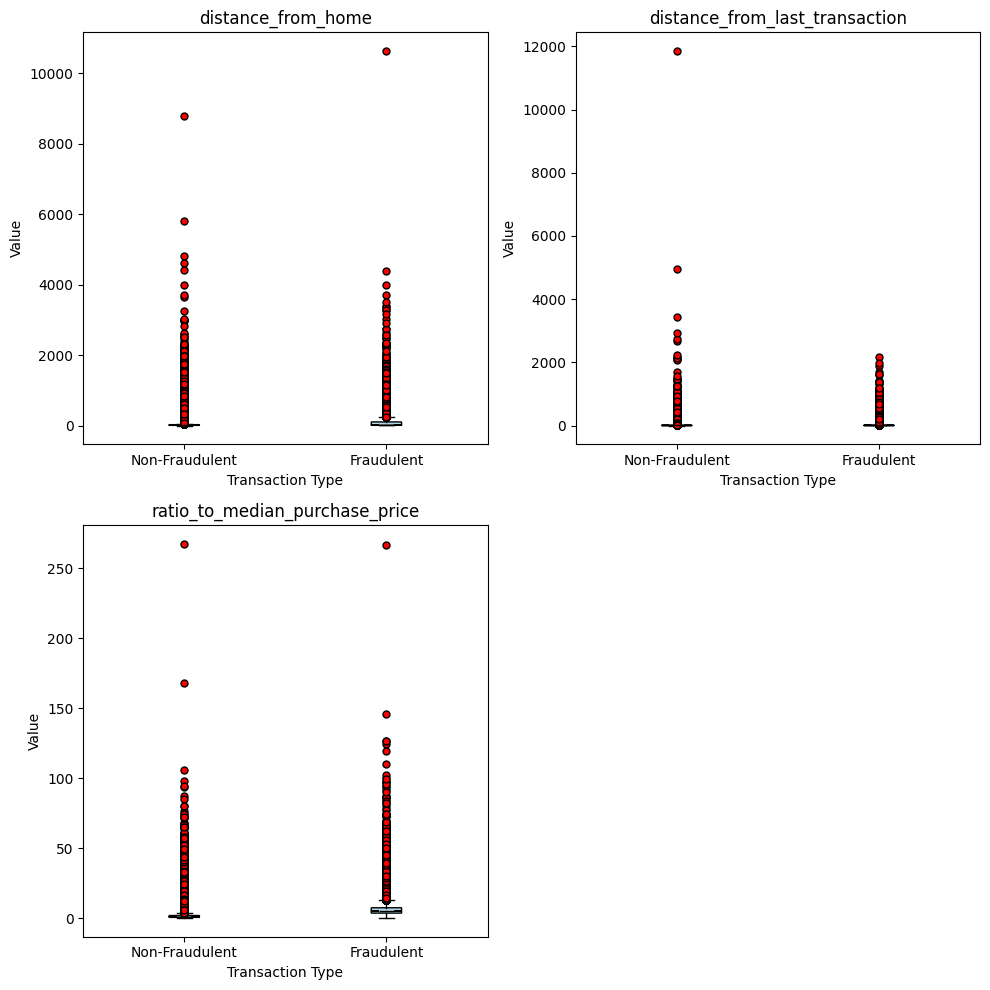

In [21]:
numerical_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    fraudulent_data = df_nn[df_nn['fraud'] == 1.0][col]
    non_fraudulent_data = df_nn[df_nn['fraud'] == 0.0][col]

    axes[i].boxplot([non_fraudulent_data, fraudulent_data], notch=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='black'),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=5),
                    medianprops=dict(color='black'),
                    labels=['Non-Fraudulent', 'Fraudulent'])
    
    axes[i].set_title(col)
    axes[i].set_xlabel('Transaction Type')
    axes[i].set_ylabel('Value')

# Remove the empty subplot if there are fewer numerical columns than subplots
if len(numerical_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

It seems that both fradulent and non-fradulent transactions have outliers. As outliers provide important information regarding fradulent transactions and we use a neural network - a model that can recognise non-linear relations within the data, we will not remove the 

In [22]:
train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)


X_train_transactions = train_transactions.drop(columns=["fraud"]).values
y_train_transactions = train_transactions.fraud.values
X_test_transactions = test_transactions.drop(columns=["fraud"]).values
y_test_transactions = test_transactions.fraud.values



print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")

print(y_train_transactions.max())

X_train_transactions has shape: (800000, 7)
y_train_transactions has shape: (800000,)
X_test_transactions has shape: (200000, 7)
y_test_transactions has shape: (200000,)
1.0


In [23]:
class FraudDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, lr=0.001):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer to prevent overfitting
        self.fc2 = nn.Linear(hidden_size, num_classes, dtype=torch.float64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [25]:
# Initialize model parameters
input_size = 7  # Number of input features
hidden_size = 64  # Number of hidden units
num_classes = 1  # Binary classification
num_epochs = 1000

model = FraudDetectionModel(input_size, hidden_size, num_classes).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = Adam(model.parameters(), lr=0.001)

In [26]:
def train(model, optim, criterion, x, y, epochs=num_epochs):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optimizer, criterion, torch.from_numpy(X_train_transactions), torch.from_numpy(y_train_transactions).view(-1, 1))

Loss at epoch 1: 2.771098123912985
Loss at epoch 2: 2.6069775798541723
Loss at epoch 3: 2.4860801630652665
Loss at epoch 4: 2.364833932230776
Loss at epoch 5: 2.2324371290566494
Loss at epoch 6: 2.119332128573101
Loss at epoch 7: 2.022380556714184
Loss at epoch 8: 1.921061133666988
Loss at epoch 9: 1.8204966644433562
Loss at epoch 10: 1.7394000087254997
Loss at epoch 11: 1.6569672877301485
Loss at epoch 12: 1.5809720945919987
Loss at epoch 13: 1.5162474277648452
Loss at epoch 14: 1.4616137199506343
Loss at epoch 15: 1.4126897005472607
Loss at epoch 16: 1.3645410158633262
Loss at epoch 17: 1.325978792511481
Loss at epoch 18: 1.2946159123789929
Loss at epoch 19: 1.2610528466319082
Loss at epoch 20: 1.2284532561097405
Loss at epoch 21: 1.2182668725317916
Loss at epoch 22: 1.1996579622601085
Loss at epoch 23: 1.1770920346523595
Loss at epoch 24: 1.1688515478925223
Loss at epoch 25: 1.1603689343709838
Loss at epoch 26: 1.1478323370278747
Loss at epoch 27: 1.1496845982819803
Loss at epoch 28